In [90]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [91]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\data\\valid.csv"  
TEST_PATH = dataroot + "\\data\\test.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

# test data
data_test = data_utils.CelebADataset(TEST_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [92]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

test_df = matched[matched['partition']==2]

In [93]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [94]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [95]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

In [96]:
df = pd.read_pickle('models\\aws_models\\run3_df.pkl') #e.g. pd.read_pickle('df.pkl')

In [97]:
# Change i to the model number you want to load
i = 2
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [108]:
#dataframe for saving predictions
test_predictions = test_df.astype(object)
test_predictions.drop(['partition'],axis=1)
target_attributes = ['Smiling','Attractive', 'Chubby','Double_Chin','Bags_Under_Eyes']
models = ['run3_smiling_model32.dms','run3_Attractive_model3.dms','run3_Chubby_model14.dms','run3_Double_Chin_model15.dms','run3_Bags_Under_Eyes_model4.dms']

In [109]:
#calculation predictions on the validation set
for k,tar_att in enumerate(target_attributes):
    print(tar_att)
    test_predictions['output_' + tar_att] = np.nan
    test_predictions['labels_argmax_'+ tar_att] = np.nan
    test_predictions['accuracy_'+ tar_att] = np.nan
    test_predictions['criterion_'+ tar_att] = np.nan

    # Load network, choose the model i
    net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)
    net.load_state_dict(torch.load('models\\aws_models\\'+models[k],map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
    net.eval()

    print(models[k])
    
    IMAGE_SHAPE = [73,60,3]
    # Root directory for dataset
    dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
    # Paths to data
    TEST_PATH = dataroot + "\\data\\test.csv"  
    IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3"
    TARGET_COL = tar_att #'Smiling'
    NUM_CLASSES = 2

    # valid data
    data_test = data_utils.CelebADataset(TEST_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

    batch_gen_test = DataLoader(data_test, batch_size, shuffle=True, num_workers=6)
    test_1_losses,test_1_accs,test_1_lengths,test_0_losses,test_0_accs,test_0_lengths = 0, 0, 0, 0, 0, 0
    test_predictions = test_predictions.astype(object)
    j=0
    with torch.no_grad():
        for batch_test in batch_gen_test:
            output = net(**get_input(batch_test))
            labels_argmax = torch.max(get_labels(batch_test), 1)[1]
            j+=1
            for i in range(len(batch_test['file'])):
                test_predictions.at[batch_test['file'][i],'output_' + tar_att] = output['out'][i]
                test_predictions.at[batch_test['file'][i],'labels_argmax_' + tar_att] = labels_argmax[i]
                test_predictions.at[batch_test['file'][i],'accuracy_'+ tar_att] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
                test_predictions.at[batch_test['file'][i],'criterion_'+ tar_att] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

Smiling
run3_smiling_model32.dms
Attractive
run3_Attractive_model3.dms
Chubby
run3_Chubby_model14.dms
Double_Chin
run3_Double_Chin_model15.dms
Bags_Under_Eyes
run3_Bags_Under_Eyes_model4.dms


In [110]:
# Should be equalt to validation accuracy in df
print('Smiling: ' + str(np.mean(test_predictions['accuracy_Smiling'])))
print('Attractive: ' + str(np.mean(test_predictions['accuracy_Attractive'])))
print('Male: ' + str(np.mean(test_predictions['accuracy_Chubby'])))
print('Pale skin: ' + str(np.mean(test_predictions['accuracy_Double_Chin'])))
print('Young: ' + str(np.mean(test_predictions['accuracy_Bags_Under_Eyes'])))

Smiling: 0.9034164913335337
Attractive: 0.7854924356276927
Male: 0.9514076745817053
Pale skin: 0.9598236649634305
Young: 0.8178038272718164


In [111]:
test_predictions

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,accuracy_Chubby,criterion_Chubby,output_Double_Chin,labels_argmax_Double_Chin,accuracy_Double_Chin,criterion_Double_Chin,output_Bags_Under_Eyes,labels_argmax_Bags_Under_Eyes,accuracy_Bags_Under_Eyes,criterion_Bags_Under_Eyes
im_id,,,,,,,,,,,,,,,,,,,,,
182638.jpg,0,1,0,1,0,0,0,0,0,0,...,tensor(1.),tensor(0.1485),"[tensor(2.0525), tensor(-2.0524)]",tensor(0),tensor(1.),tensor(0.0164),"[tensor(0.8830), tensor(-0.8841)]",tensor(1),tensor(0.),tensor(1.9249)
182639.jpg,0,0,0,0,0,0,0,1,1,0,...,tensor(1.),tensor(0.0614),"[tensor(1.9837), tensor(-1.9837)]",tensor(0),tensor(1.),tensor(0.0187),"[tensor(1.2251), tensor(-1.2250)]",tensor(0),tensor(1.),tensor(0.0828)
182640.jpg,0,0,1,0,0,0,0,0,0,0,...,tensor(1.),tensor(0.0277),"[tensor(2.3305), tensor(-2.3305)]",tensor(0),tensor(1.),tensor(0.0094),"[tensor(0.8189), tensor(-0.8179)]",tensor(0),tensor(1.),tensor(0.1778)
182641.jpg,0,0,1,0,0,0,0,0,0,0,...,tensor(1.),tensor(0.0367),"[tensor(1.7673), tensor(-1.7673)]",tensor(0),tensor(1.),tensor(0.0288),"[tensor(1.4680), tensor(-1.4661)]",tensor(0),tensor(1.),tensor(0.0518)
182642.jpg,0,0,0,0,0,0,0,0,1,0,...,tensor(1.),tensor(0.2020),"[tensor(1.3289), tensor(-1.3288)]",tensor(0),tensor(1.),tensor(0.0678),"[tensor(0.5770), tensor(-0.5755)]",tensor(0),tensor(1.),tensor(0.2745)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,tensor(1.),tensor(0.0126),"[tensor(2.4351), tensor(-2.4351)]",tensor(0),tensor(1.),tensor(0.0076),"[tensor(1.6593), tensor(-1.6591)]",tensor(0),tensor(1.),tensor(0.0356)
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,tensor(1.),tensor(0.1187),"[tensor(1.8939), tensor(-1.8938)]",tensor(0),tensor(1.),tensor(0.0224),"[tensor(0.3005), tensor(-0.3012)]",tensor(0),tensor(1.),tensor(0.4369)
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,tensor(1.),tensor(0.0590),"[tensor(1.2388), tensor(-1.2387)]",tensor(0),tensor(1.),tensor(0.0806),"[tensor(1.9059), tensor(-1.9068)]",tensor(0),tensor(1.),tensor(0.0218)


In [112]:
df_att = pd.DataFrame(index = matched.iloc[:,0:-1].columns, columns=target_attributes)
for i,tar_att in enumerate(target_attributes):
    #calculating accuracies for all protected attributes
    attributes = matched.iloc[:,0:-1].drop(tar_att,axis=1).columns
    for att in attributes:

        att_ = test_predictions.loc[:][att]
        t_ = test_predictions.loc[:][tar_att]

        att_1 = np.where(att_==1)
        att_0 = np.where(att_==0)

        df_att.loc[att][tar_att] = np.mean(test_predictions.iloc[att_1]['accuracy_'+ tar_att])/np.mean(test_predictions.iloc[att_0]['accuracy_'+tar_att])

In [113]:
df_att2 = df_att.loc[['Rosy_Cheeks','Gray_Hair','Bags_Under_Eyes','Bald','Chubby','Double_Chin','Goatee','High_Cheekbones','Young','Narrow_Eyes','Blond_Hair','Male','Arched_Eyebrows','Receding_Hairline','Attractive','Oval_Face','Big_Lips','Sideburns','Big_Nose']].sort_values('Smiling')

In [114]:
df_att2 = df_att2.astype('float')

In [115]:
df_att2.describe()

,Smiling,Attractive,Chubby,Double_Chin,Bags_Under_Eyes
count,19.000000,18.000000,18.000000,18.000000,18.000000
mean,0.993233,1.062079,0.930948,0.938646,0.917504
std,0.031109,0.092923,0.143368,0.128302,0.180653
min,0.943537,0.934962,0.554875,0.597517,0.645624
25%,0.968258,0.988598,0.870256,0.888395,0.778328
50%,0.994014,1.048894,0.948489,0.968260,0.876293
75%,1.019073,1.103164,1.025349,1.023008,1.094867
max,1.041757,1.227821,1.158576,1.136280,1.199692


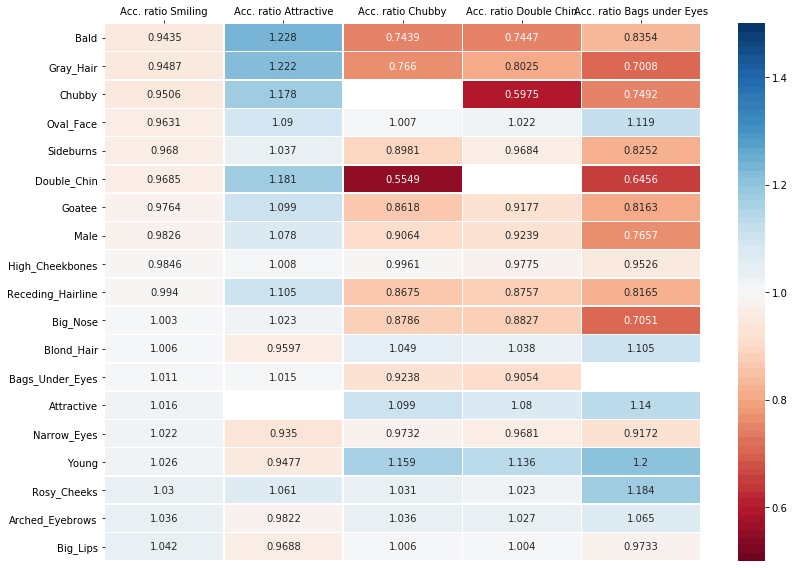

In [123]:
plt.figure(figsize = (12,8))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0.5, vmax=1.5, cmap=cmap,annot=True, linewidths=.5, fmt='.4g')
ax = sns.heatmap(df_att2, mask=df_att2.isnull(),center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['Acc. ratio Smiling','Acc. ratio Attractive','Acc. ratio Chubby','Acc. ratio Double Chin','Acc. ratio Bags under Eyes'])
ax.set_yticklabels(list(df_att2.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig('heat_targets.png',dpi=500)

In [42]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    pred_label = torch.max(get_labels(sample_batched), 1)[1]
    
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        #print(bias[i])
        print('Output of NN: ',output['out'][i])
        print('Predicted label: ', pred_label[i])

In [45]:
batch_valid

{'file': ['charlotte.jpg'],
 'image': tensor([[[[199., 199., 199.,  ..., 217., 216., 216.],
           [202., 202., 202.,  ..., 219., 219., 219.],
           [202., 202., 202.,  ..., 220., 220., 220.],
           ...,
           [ 59.,  58.,  52.,  ...,  93.,  84.,  75.],
           [ 58.,  57.,  52.,  ...,  93.,  85.,  74.],
           [ 60.,  60.,  52.,  ...,  93.,  82.,  70.]],
 
          [[195., 195., 195.,  ..., 213., 212., 212.],
           [198., 198., 198.,  ..., 215., 215., 215.],
           [198., 198., 198.,  ..., 216., 216., 216.],
           ...,
           [ 17.,  18.,  15.,  ...,  43.,  37.,  28.],
           [ 16.,  17.,  15.,  ...,  43.,  35.,  27.],
           [ 18.,  20.,  17.,  ...,  43.,  32.,  22.]],
 
          [[184., 184., 184.,  ..., 204., 203., 203.],
           [187., 187., 187.,  ..., 206., 206., 206.],
           [187., 187., 187.,  ..., 207., 207., 207.],
           ...,
           [ 27.,  27.,  23.,  ...,  54.,  47.,  38.],
           [ 26.,  26.,  23.,

<Figure size 432x288 with 0 Axes>

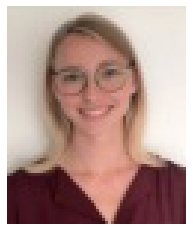

tensor([0., 1.], dtype=torch.float64)


KeyError: 0

In [44]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()

In [50]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\images_resize\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [51]:
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        ac = accuracy(output['out'],labels_argmax)
        print(ac)

tensor(0.8000)


In [52]:
output

{'out': tensor([[-1.7870,  1.7862],
         [-0.1785,  0.1781],
         [-2.7959,  2.7955],
         [-3.3320,  3.3327],
         [ 1.2387, -1.2403]])}

In [53]:
batch_valid

{'file': ['martin.jpg', 'ole.jpg', 'charlotte.jpg', '000108.jpg', 'pratt.jpg'],
 'image': tensor([[[[171., 171., 170.,  ..., 214., 216., 218.],
           [165., 165., 167.,  ..., 216., 218., 220.],
           [160., 160., 162.,  ..., 218., 220., 222.],
           ...,
           [116., 116., 118.,  ...,  75.,  65.,  71.],
           [117., 115., 116.,  ...,  77.,  78.,  82.],
           [112., 110., 110.,  ...,  82.,  79.,  80.]],
 
          [[184., 184., 184.,  ..., 224., 226., 228.],
           [178., 178., 180.,  ..., 226., 228., 230.],
           [170., 173., 175.,  ..., 228., 230., 232.],
           ...,
           [137., 137., 139.,  ...,  80.,  70.,  76.],
           [137., 135., 136.,  ...,  81.,  82.,  86.],
           [132., 130., 130.,  ...,  83.,  80.,  84.]],
 
          [[193., 193., 193.,  ..., 234., 236., 238.],
           [187., 187., 189.,  ..., 236., 238., 240.],
           [180., 182., 184.,  ..., 238., 240., 242.],
           ...,
           [128., 128., 130.,  .